## Notes
* use precipitation and boundary layer height data?
* use data from previous days?
* what type of model should we make?
* use data from all cities combined

## Importing Libraries

In [75]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing, svm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

## Initiating directories

In [29]:
ROOT_DIR = os.getcwd() + '/../'
try:
    with open (ROOT_DIR + '/configuration.yml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')
DATA_DIR = ROOT_DIR + config['data']['final'] + '/'
cities = pd.read_csv(ROOT_DIR + config['cities'])

### Cities information, eg. to loop over city names:

* **ALE:**	Alert, Canada
* **ABZ:**	Annaberg-Buchholz, Germany
* **ASP:**	Aspvreten, Sweden
* **BOT:**	Botsalano, South Africa
* **BSL:**	Bösel (Südoldenburg), Germany
* **EGB:**	Egbert, Canada
* **HEL:**	Helsinki, Finland
* **HPB:**	Hohenpeissenberg, Germany
* **HYY:**	Hyytiälä, Finland
* **KCE:**	Kosetice, Czech Republic
* **KPZ:**	K-Puszta, Hungary
* **MHD:**	Mace Head, Ireland
* **MAR:**	Marikana, South Africa
* **MLP:**	Melpitz, Germany
* **NAN:**	Nanjing, China
* **NEU:**	Neuglobsow, Germany
* **SAO:**	São Paulo, Brazil
* **SCH:**	Schauinsland, Germany
* **SGP:**	Southern Great Plains, Oklahoma, US
* **VIE:**	Vielsalm, Belgium
* **VAR:**	Värriö, Finland
* **WAL:**	Waldhof, Germany

In [3]:
cities.city.unique()

array(['ALE', 'ABZ', 'ASP', 'BOT', 'BSL', 'EGB', 'HEL', 'HPB', 'HYY',
       'KCE', 'KPZ', 'MHD', 'MAR', 'MLP', 'NAN', 'NEU', 'SAO', 'SCH',
       'SGP', 'VIE', 'VAR', 'WAL'], dtype=object)

In [4]:
city = cities.city[6]
city

'HEL'

## Loading and pre-processing the data

In [30]:
df = pd.read_csv(DATA_DIR + city + '.csv', index_col='date')
df.head()

,concentration,t,co
date,,,
2005-01-01,745.769167,271.50780,1.924972e-07
2005-01-02,374.991806,272.57120,1.903695e-07
2005-01-03,265.290294,272.60297,1.779340e-07
2005-01-04,304.682014,270.91785,2.032431e-07
2005-01-05,409.387986,272.37310,2.047700e-07


In [31]:
# calculating moving averages
df_ma = df.copy()
df_ma = df_ma.rolling(window=30).mean()

# normalizing the data
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(x_scaled)
df_scaled.columns = df.columns.values

# log-transforming the data
df_log = df_scaled.transform(np.log)

# calculating moving averages for log-transformed data
df_log_ma = df_log.copy()
df_log_ma = df_log_ma.rolling(window=30).mean()

In [32]:
df_scaled.head()

,concentration,t,co
0,0.088144,0.406259,0.133595
1,0.040896,0.430218,0.131089
2,0.026917,0.430934,0.116442
3,0.031937,0.392967,0.146251
4,0.045279,0.425755,0.148049


## Visualizations

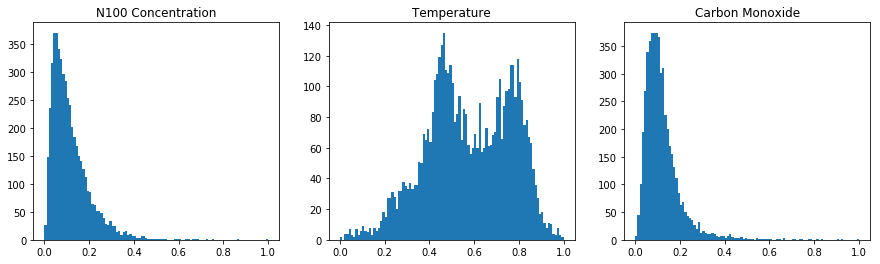

In [9]:
# plotting value distributions
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(4)

ax[0].hist(df_scaled.concentration, bins=100)
ax[1].hist(df_scaled.t, bins=100)
ax[2].hist(df_scaled.co, bins=100)

ax[0].set_title('N100 Concentration')
ax[1].set_title('Temperature')
ax[2].set_title('Carbon Monoxide');

N100 Concentration and Carbon Monoxide have a high positive skew and should therefore be log-tranformed

In [41]:
# removing rows that contain infinity (removes three rows)
subset_mask = np.isinf(df_log).any(axis=1) == False

df_log_subset = df_log.loc[subset_mask]
df_scaled_subset = df_scaled.loc[subset_mask]
df_subset = df.reset_index().loc[subset_mask]

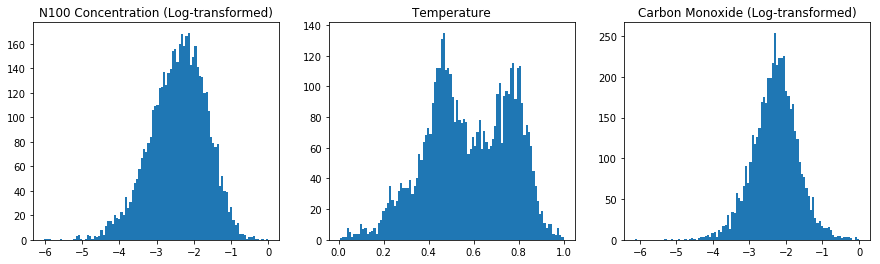

In [14]:
# plotting value distributions
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(4)

ax[0].hist(df_log_subset.concentration, bins=100)
ax[1].hist(df_scaled_subset.t, bins=100)
ax[2].hist(df_log_subset.co, bins=100)

ax[0].set_title('N100 Concentration (Log-transformed)')
ax[1].set_title('Temperature')
ax[2].set_title('Carbon Monoxide (Log-transformed)');

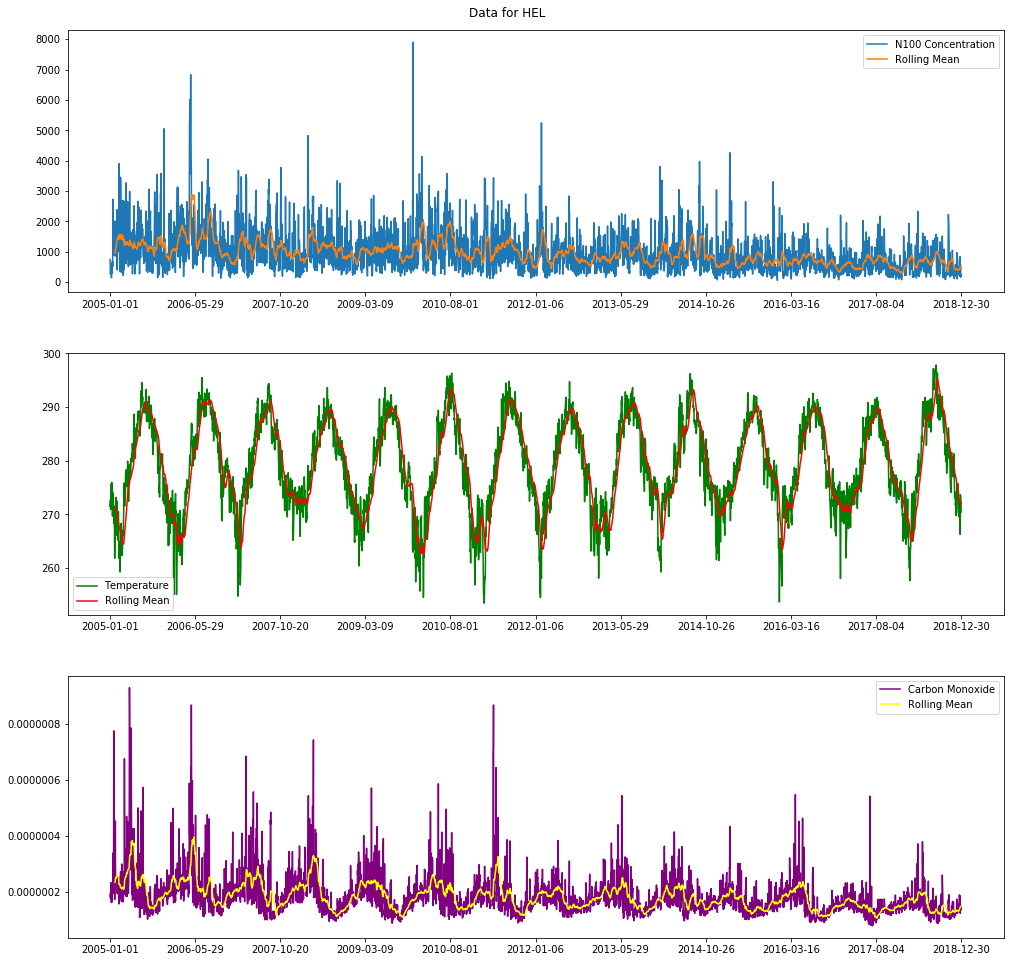

In [8]:
# plotting original data and trend (moving average)
idx = df.shape[0]
step = int(idx / 10)
xticks = pd.Series(df.index).iloc[list(range(0,idx,step))]

fig, ax = plt.subplots(3, 1)
fig.set_figwidth(15)
fig.set_figheight(14)

ax[0].plot(df.concentration[:idx], label='N100 Concentration')
ax[0].plot(df_ma.concentration[:idx], label='Rolling Mean')

ax[1].plot(df.t[:idx], label='Temperature', c='green')
ax[1].plot(df_ma.t[:idx], label='Rolling Mean', c='red')

ax[2].plot(df.co[:idx], label='Carbon Monoxide', c='purple')
ax[2].plot(df_ma.co[:idx], label='Rolling Mean', c='yellow')

for i in range(3):
    ax[i].legend()
    ax[i].set_xticks(xticks)

fig.tight_layout(pad=4)
fig.suptitle('Data for '+city);

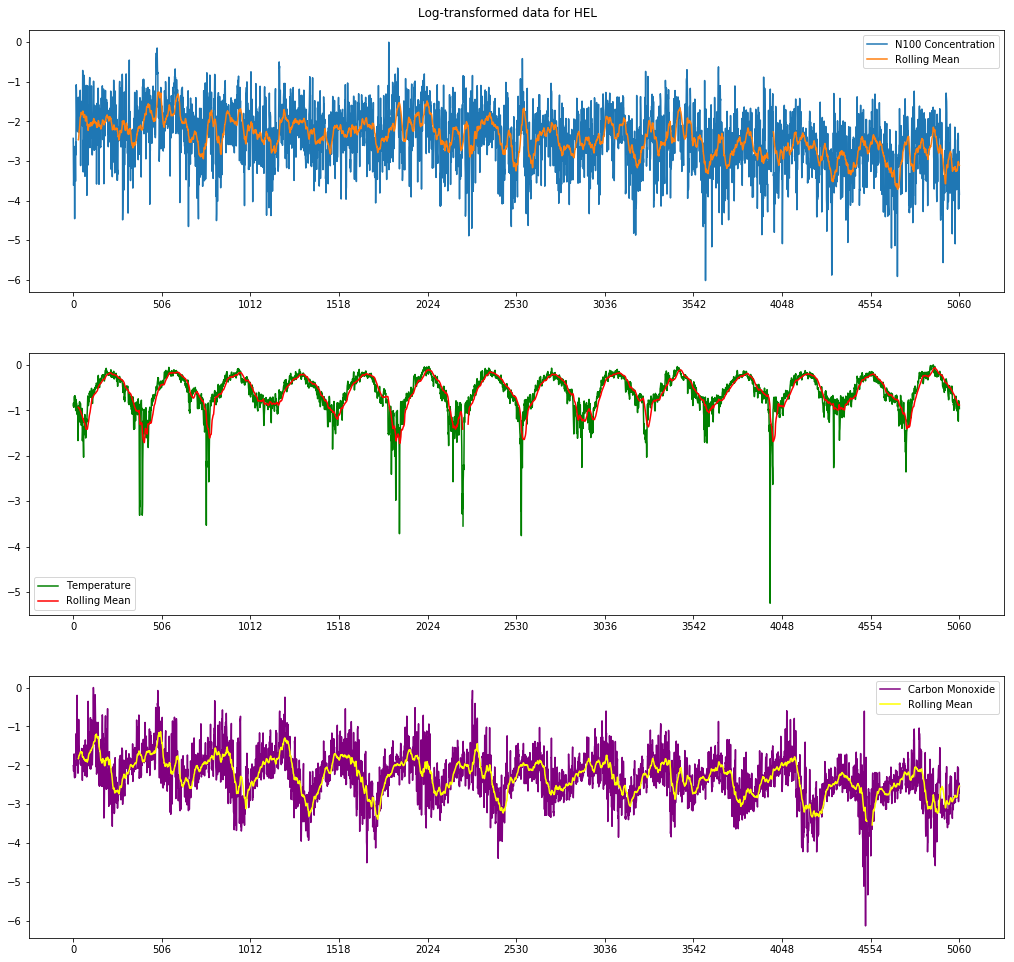

In [9]:
# plotting log-transformed data and trend (moving average)
idx = df_log.shape[0]
step = int(idx / 10)
xticks = pd.Series(df_log.index).iloc[list(range(0,idx,step))]

fig, ax = plt.subplots(3, 1)
fig.set_figwidth(15)
fig.set_figheight(14)

ax[0].plot(df_log.concentration[:idx], label='N100 Concentration')
ax[0].plot(df_log_ma.concentration[:idx], label='Rolling Mean')

ax[1].plot(df_log.t[:idx], label='Temperature', c='green')
ax[1].plot(df_log_ma.t[:idx], label='Rolling Mean', c='red')

ax[2].plot(df_log.co[:idx], label='Carbon Monoxide', c='purple')
ax[2].plot(df_log_ma.co[:idx], label='Rolling Mean', c='yellow')

for i in range(3):
    ax[i].legend()
    ax[i].set_xticks(xticks)

fig.tight_layout(pad=4)
fig.suptitle('Log-transformed data for '+city);

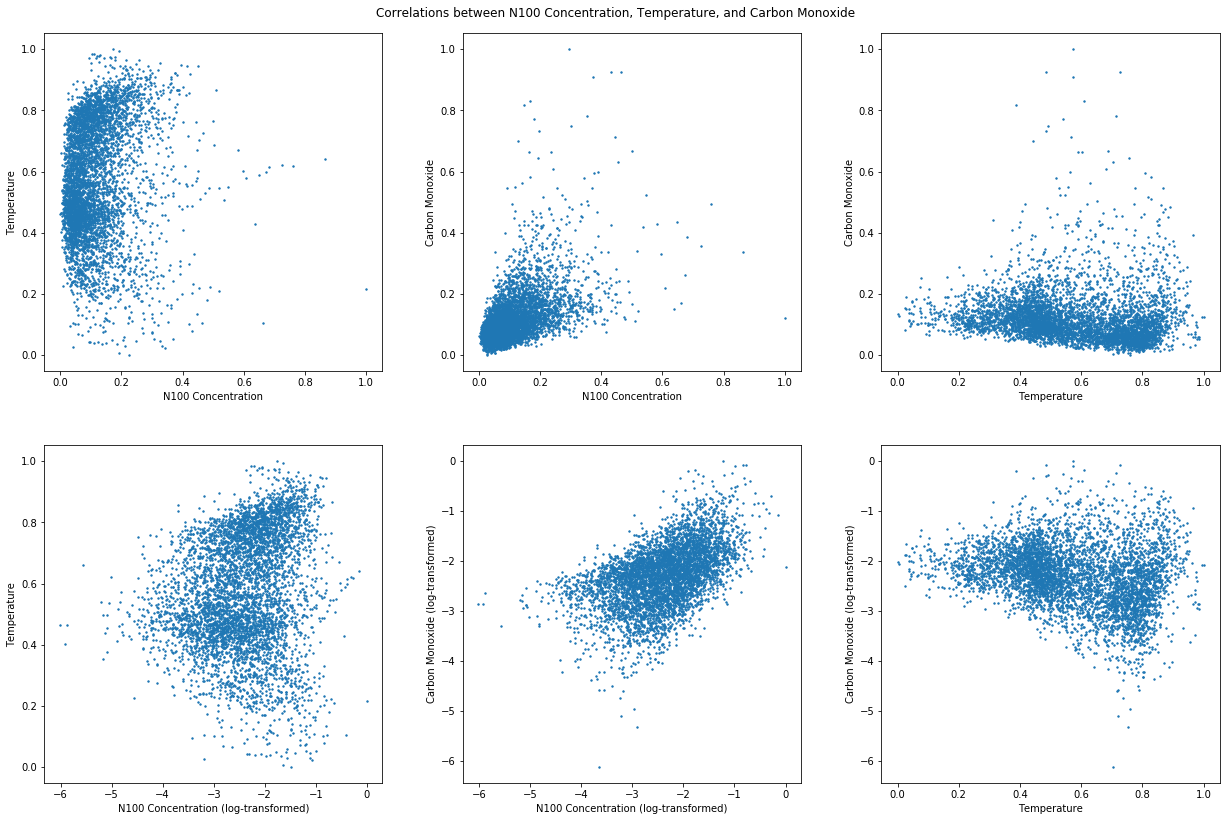

In [10]:
# plotting correlations of variables
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(18,12)
fig.suptitle('Correlations between N100 Concentration, Temperature, and Carbon Monoxide')

ax[0, 0].scatter(df_scaled.concentration, df_scaled.t, s=2)
ax[0, 1].scatter(df_scaled.concentration, df_scaled.co, s=2)
ax[0, 2].scatter(df_scaled.t, df_scaled.co, s=2)

ax[1, 0].scatter(df_log.concentration, df_scaled.t, s=2)
ax[1, 1].scatter(df_log.concentration, df_log.co, s=2)
ax[1, 2].scatter(df_scaled.t, df_log.co, s=2)

for i in range(2):
    n100 = 'N100 Concentration'
    t = 'Temperature'
    co = 'Carbon Monoxide'
    
    if i == 1:
        log = ' (log-transformed)'
        n100 += log
        co += log
    
    ax[i, 0].set_xlabel(n100)
    ax[i, 1].set_xlabel(n100)
    ax[i, 2].set_xlabel(t)

    ax[i, 0].set_ylabel(t)
    ax[i, 1].set_ylabel(co)
    ax[i, 2].set_ylabel(co)
    
fig.tight_layout(pad=4);

In [11]:
# calculating correlation coefficients
pr = 4  # precision

print('NORMALIZED DATA')
print('Correlations between...')
print('\tN100 and T:',
      np.round(np.corrcoef(df_scaled.concentration, df_scaled.t)[0,1], pr))
print('\tN100 and CO:',
      np.round(np.corrcoef(df_scaled.concentration, df_scaled.co)[0,1], pr))
print('\tT and CO:',
      np.round(np.corrcoef(df_scaled.t, df_scaled.co)[0,1], pr))

print('\n')
print('LOG-TRANSFORMED DATA (N100 and CO)')
print('Correlations between...')
print('\tN100 and T:',
      np.round(np.corrcoef(df_log_subset.concentration, df_scaled_subset.t)[0,1], pr))
print('\tN100 and CO:',
      np.round(np.corrcoef(df_log_subset.concentration, df_log_subset.co)[0,1], pr))
print('\tT and CO:',
      np.round(np.corrcoef(df_scaled_subset.t, df_log_subset.co)[0,1], pr))

NORMALIZED DATA
Correlations between...
	N100 and T: 0.1286
	N100 and CO: 0.508
	T and CO: -0.1091


LOG-TRANSFORMED DATA (N100 and CO)
Correlations between...
	N100 and T: 0.1775
	N100 and CO: 0.5039
	T and CO: -0.2429


Using the log-transform actually made the correlations stronger. (When also using a log-transform for the temperature data the correlation was weakened.)

## Simple Scikit Learn Models
### Preparing the data

In [42]:
df_comb = pd.DataFrame(np.array([df_log_subset.concentration, df_scaled_subset.t, df_log_subset.co]).T)
df_comb.columns = df.columns.values
df_comb.head()

,concentration,t,co
0,-2.428784,0.406259,-2.012946
1,-3.196716,0.430218,-2.031882
2,-3.614992,0.430934,-2.150360
3,-3.443997,0.392967,-1.922431
4,-3.094905,0.425755,-1.910210


In [56]:
# splitting the data into training, testing, and validation sets
split = int(len(df_comb) * 0.75)

y_train, y_test = df_comb.concentration[0:split], df_subset.concentration[split:len(df_subset)]
y_test = y_test.reset_index(drop=True)

X_train = df_comb[['t', 'co']][0:split]
X_test = df_comb[['t', 'co']][split:len(df_comb)]
X_test = X_test.reset_index(drop=True)

### Functions for evaluating models

In [57]:
# fitting a min_max_scaler to the concentration data
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = min_max_scaler.fit(df_subset.concentration.values.reshape(-1,1))

In [68]:
# function for reverse transforming the data
def rev_trans(predictions):
    predictions = np.exp(predictions)
    predictions = min_max_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

In [84]:
# evaluating the performance of the model
def eval_model(predictions, model):
    error = np.sqrt(mean_squared_error(y_test, predictions))
    print('RMSE on test set: %.3f' % error)

    test_score = model.score(X_test, y_test)
    print('Test score: %.3f' % test_score)

    training_score = model.score(X_train, y_train)
    print('Training score: %.3f' % training_score)

In [88]:
def plot_results(name, predictions):
    plt.figure(figsize=(15,5))
    plt.title('Performance of ' + name + ' Model - Test Set')
    plt.plot(np.array(y_test), label='Observed')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    plt.xlabel('Time step')
    plt.ylabel('N100 concentration');

### Models

RMSE on test set: 363.189
Test score: -2.659
Training score: 0.329


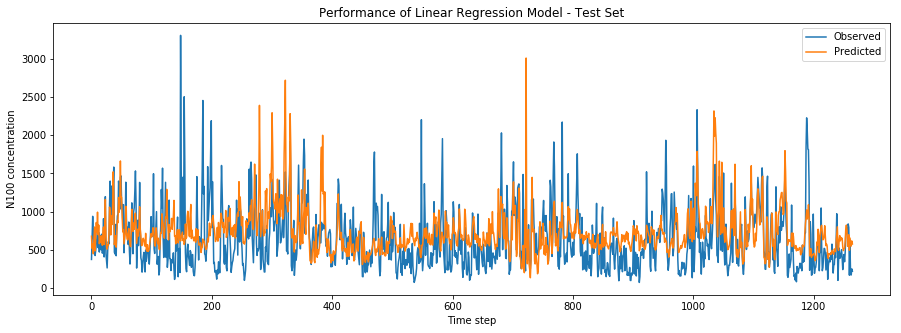

In [93]:
# Linear Regression
model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(X_test)
predictions = rev_trans(predictions)

eval_model(predictions, model)
plot_results('Linear Regression', predictions)

C:\Users\ellar\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RMSE on test set: 329.365
Test score: -2.659
Training score: 0.506


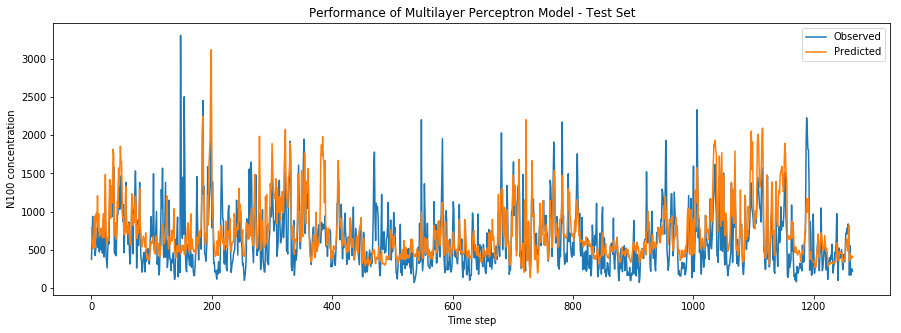

In [90]:
# Multilayer Perceptron
model = MLPRegressor(early_stopping=True).fit(X_train, y_train)
predictions = model.predict(X_test)
predictions = rev_trans(predictions)

eval_model(predictions, model)
plot_results('Multilayer Perceptron', predictions)

C:\Users\ellar\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


RMSE on test set: 366.594
Test score: -2.659
Training score: 0.486


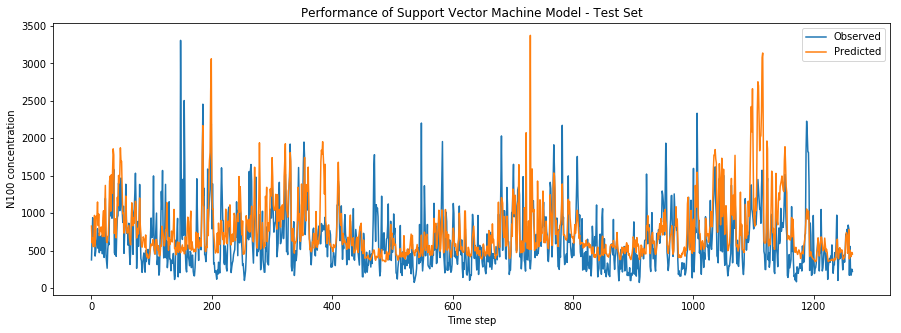

In [91]:
# Support Vector Machine
model = svm.SVR().fit(X_train, y_train)
predictions = model.predict(X_test)
predictions = rev_trans(predictions)

eval_model(predictions, model)
plot_results('Support Vector Machine', predictions)

RMSE on test set: 390.718
Test score: -2.659
Training score: 0.900


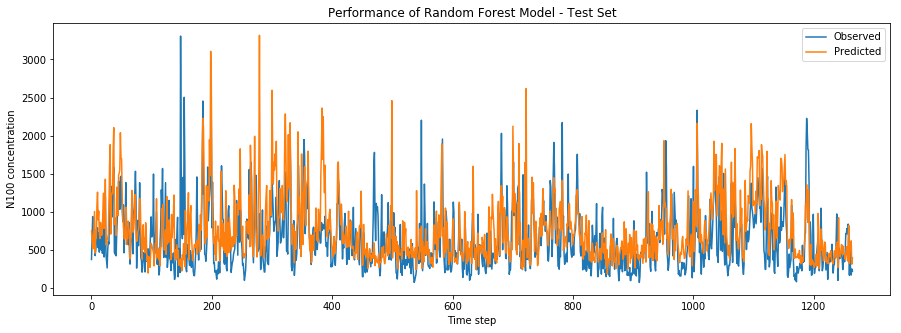

In [92]:
# Random Forest
model = RandomForestRegressor(n_estimators=15).fit(X_train, y_train)
predictions = model.predict(X_test)
predictions = rev_trans(predictions)

eval_model(predictions, model)
plot_results('Random Forest', predictions)

The random forest model seems to give by far the best performance (in terms of training score). The multilayer perceptron model achieves the lowest RMSE.